# Description

Use bid-ask data to analyze and simulate trading execution quality.

In [44]:
%load_ext autoreload
%autoreload 2

import logging

import numpy as np
import pandas as pd

import core.config as cconfig
import core.finance as cofinanc
import core.plotting as coplotti
import core.statistics as costatis
import dataflow.core as dtfcore
import dataflow.pipelines.execution.execution_pipeline as dtfpexexpi
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hprint as hprint
import im_v2.common.data.client.im_raw_data_client as imvcdcimrdc
import im_v2.common.universe.universe_utils as imvcuunut
import oms
import oms.broker.ccxt.ccxt_aggregation_functions as obccagfu
import oms.broker.ccxt.ccxt_execution_quality as obccexqu
import oms.broker.ccxt.ccxt_logs_reader as obcclore

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO  # Git
  branch_name='CmTask4937_Rename_plot_slippage_boxplot'
  hash='31f2fe440'
  # Last commits:
    * 31f2fe440 Paul     Update notebook (#5036)                                           (  13 hours ago) Mon Aug 14 21:07:10 2023  (HEAD -> CmTask4937_Rename_plot_slippage_boxplot, origin/master, origin/HEAD, origin/CmTask4937_Rename_plot_slippage_boxplot, master)
    * f98698cd6 Paul     Update notebooks (#5034)                                          (  14 hours ago) Mon Aug 14 20:13:58 2023           
    * db7899e01 Paul     Cmamp task5027 add makertaker breakdown to transaction costpnl analysis in notebook (#5032) (  18 hours ago) Mon Aug 14 16:08:40 2023           
# Machine info
  system=Linux
  node name=98c4dafda575
  release=5.15.0-1033-aws
  version=#37~20.04.1-Ubuntu SMP Fri Mar 17 11:39:30 UTC 2023
  machine=x86_64
  processor=x86_64
  cpu count=8
  cpu freq=scpufreq(current=2499.998, min=0.0, max=0.0)
  memory=svmem(total=33292873728, available=18933440512, percent

# Config

In [46]:
config = cconfig.get_config_from_env()
if config:
    # Get config from env when running the notebook via the `run_notebook.py` script, e.g.,
    # in the system reconciliation flow.
    _LOG.info("Using config from env vars")
else:
    system_log_dir = "/shared_data/ecs/test/twap_experiment/20230814_1"
    use_historical = False
    config_dict = {
        "meta": {
            "use_historical": use_historical
        },
        "system_log_dir": system_log_dir
    }
    config = cconfig.Config.from_dict(config_dict)
print(config)

meta: 
  use_historical: False
system_log_dir: /shared_data/ecs/test/twap_experiment/20230814_1


In [47]:
system_log_dir = config["system_log_dir"]
bar_duration = "5T"
id_col = "asset_id"

In [48]:
ccxt_log_reader = obcclore.CcxtLogsReader(system_log_dir)

In [49]:
btc_usdt_id = 1467591036

In [50]:
# Use historical data for experiment runs older than 48h.
use_historical = config["meta"]["use_historical"]

# Load order responses and fills

In [51]:
ccxt_order_response_df = ccxt_log_reader.load_ccxt_order_response_df()
ccxt_executed_trades_df = ccxt_log_reader.load_ccxt_trades_df()

Loading files from '/shared_data/ecs/test/twap_experiment/20230814_1/ccxt_child_order_responses':   0%|       …

Loading files from '/shared_data/ecs/test/twap_experiment/20230814_1/child_order_fills/ccxt_trades':   0%|    …

In [52]:
ccxt_executed_trades_df.head()

,timestamp,datetime,symbol,asset_id,id,order,side,takerOrMaker,price,amount,cost,transaction_cost,fees_currency,realized_pnl,first_timestamp,last_timestamp,first_datetime,last_datetime,buy_count,sell_count,taker_count,maker_count
timestamp,,,,,,,,,,,,,,,,,,,,,,
2023-08-14 19:05:04.294000+00:00,2023-08-14 19:05:04.294000+00:00,2023-08-14 19:05:04.294000+00:00,BTC/USDT:USDT,1467591036,4007015967,180292745435,buy,maker,29337.2000,0.001,29.3372,0.005867,USDT,0.0,2023-08-14 19:05:04.294000+00:00,2023-08-14 19:05:04.294000+00:00,2023-08-14 19:05:04.294000+00:00,2023-08-14 19:05:04.294000+00:00,1,0,0,1
2023-08-14 19:05:15.916000+00:00,2023-08-14 19:05:15.916000+00:00,2023-08-14 19:05:15.916000+00:00,SAND/USDT:USDT,4516629366,604494241,13935179300,buy,maker,0.3888,103.000,40.0464,0.008009,USDT,0.0,2023-08-14 19:05:15.916000+00:00,2023-08-14 19:05:15.916000+00:00,2023-08-14 19:05:15.916000+00:00,2023-08-14 19:05:15.916000+00:00,1,0,0,1
2023-08-14 19:05:24.922000+00:00,2023-08-14 19:05:24.922000+00:00,2023-08-14 19:05:24.922000+00:00,STORJ/USDT:USDT,2425308589,215676219,5793828911,buy,maker,0.2901,50.000,14.5050,0.002901,USDT,0.0,2023-08-14 19:05:24.922000+00:00,2023-08-14 19:05:24.922000+00:00,2023-08-14 19:05:24.922000+00:00,2023-08-14 19:05:24.922000+00:00,1,0,0,1
2023-08-14 19:05:10.044000+00:00,2023-08-14 19:05:10.044000+00:00,2023-08-14 19:05:10.044000+00:00,AVAX/USDT:USDT,8717633868,518968535,15556745909,buy,maker,12.2780,1.000,12.2780,0.002456,USDT,0.0,2023-08-14 19:05:10.044000+00:00,2023-08-14 19:05:10.044000+00:00,2023-08-14 19:05:10.044000+00:00,2023-08-14 19:05:10.044000+00:00,1,0,0,1
2023-08-14 19:05:28.238000+00:00,2023-08-14 19:05:28.238000+00:00,2023-08-14 19:05:28.238000+00:00,APE/USDT:USDT,6051632686,407706468,10155119336,sell,maker,2.0580,15.000,30.8700,0.006174,USDT,0.0,2023-08-14 19:05:28.238000+00:00,2023-08-14 19:05:28.238000+00:00,2023-08-14 19:05:28.238000+00:00,2023-08-14 19:05:28.238000+00:00,0,1,0,1


In [53]:
executed_trades_prices = obccagfu.compute_buy_sell_prices_by_bar(
    ccxt_executed_trades_df, bar_duration, groupby_id_col=id_col
)

In [54]:
oms_child_order_df = ccxt_log_reader.load_oms_child_order_df()

Loading files from '/shared_data/ecs/test/twap_experiment/20230814_1/oms_child_orders':   0%|          | 0/620…

In [55]:
ccxt_order_response_df.head(3)

,info,order,client_order_id,timestamp,datetime,last_trade_timestamp,lastUpdateTimestamp,symbol,order_type,time_in_force,post_only,reduce_only,side,order_price,triggerPrice,order_amount,cost,average,filled,remaining,status,fee,trades,fees,stop_price,takeProfitPrice,stopLossPrice,order_update_timestamp,order_update_datetime
0,"{'orderId': '11978567410', 'symbol': 'GMTUSDT'...",11978567410,x-xcKtGhcua696504fa76a1e6db09a42,1692039902305,2023-08-14T19:05:02.305Z,NaN,1692039902305,GMT/USDT:USDT,limit,GTC,False,False,sell,0.2033,None,151.0,0.0,NaN,0.0,151.0,open,"{'currency': None, 'cost': None, 'rate': None}",[],"[{'currency': None, 'cost': None, 'rate': None}]",None,None,None,1692039902305,2023-08-14 19:05:02.305000+00:00
1,"{'orderId': '11978569826', 'symbol': 'GMTUSDT'...",11978569826,x-xcKtGhcuea05684007c4f773d23ab8,1692039962767,2023-08-14T19:06:02.767Z,NaN,1692039962767,GMT/USDT:USDT,limit,GTC,False,False,sell,0.2032,None,151.0,0.0,NaN,0.0,151.0,open,"{'currency': None, 'cost': None, 'rate': None}",[],"[{'currency': None, 'cost': None, 'rate': None}]",None,None,None,1692039962767,2023-08-14 19:06:02.767000+00:00
2,"{'orderId': '11978572688', 'symbol': 'GMTUSDT'...",11978572688,x-xcKtGhcu29ea7c262adda3cde2145d,1692040022449,2023-08-14T19:07:02.449Z,NaN,1692040022449,GMT/USDT:USDT,limit,GTC,False,False,sell,0.2031,None,151.0,0.0,NaN,0.0,151.0,open,"{'currency': None, 'cost': None, 'rate': None}",[],"[{'currency': None, 'cost': None, 'rate': None}]",None,None,None,1692040022449,2023-08-14 19:07:02.449000+00:00


# Load bid-ask data

In [56]:
# TODO(Paul): Refine the cuts around the first and last bars.
start_timestamp = ccxt_order_response_df["order_update_datetime"].min()
_LOG.info("start_timestamp=%s", start_timestamp)
end_timestamp = ccxt_executed_trades_df["datetime"].max()
_LOG.info("end_timestamp=%s", end_timestamp)

INFO  start_timestamp=2023-08-14 19:05:02.305000+00:00
INFO  end_timestamp=2023-08-14 19:29:54.079000+00:00


In [57]:
def load_bid_ask_data(
    start_timestamp,
    end_timestamp,
    use_historical,
    asset_ids,
) -> pd.DataFrame:
    if use_historical:
        signature = "periodic_daily.airflow.archived_200ms.parquet.bid_ask.futures.v7.ccxt.binance.v1_0_0"
        reader = imvcdcimrdc.RawDataReader(signature, stage="preprod")
    else:
        signature = "realtime.airflow.downloaded_200ms.postgres.bid_ask.futures.v7.ccxt.binance.v1_0_0"
        reader = imvcdcimrdc.RawDataReader(signature)
    bad = reader.read_data(start_timestamp, end_timestamp)
    hdbg.dassert(not bad.empty, "Requested bid-ask data not available.")
    #
    currency_pair_to_full_symbol = {
        x: "binance::" + x for x in bad["currency_pair"].unique()
    }
    asset_id_to_full_symbol = imvcuunut.build_numerical_to_string_id_mapping(
        currency_pair_to_full_symbol.values()
    )
    full_symbol_mapping_to_asset_id = {
        v: k for k, v in asset_id_to_full_symbol.items()
    }
    currency_pair_to_asset_id = {
        x: full_symbol_mapping_to_asset_id[currency_pair_to_full_symbol[x]]
        for x in bad["currency_pair"].unique()
    }
    # Add asset_ids
    list(currency_pair_to_asset_id.values())
    bad_asset_id = bad["currency_pair"].apply(
        lambda x: currency_pair_to_asset_id[x]
    )
    bad["asset_id"] = bad_asset_id
    #
    if asset_ids is not None:
        bad = bad[bad["asset_id"].isin(asset_ids)]
    if not use_historical:
        bad = bad[
            ["bid_price_l1", "ask_price_l1", "asset_id", "knowledge_timestamp"]
        ].rename(
            columns={"bid_price_l1": "bid_price", "ask_price_l1": "ask_price"},
        )
        bad = bad.pivot_table(columns=["asset_id"], index="knowledge_timestamp")
    else:
        bad = bad[["bid_price_l1", "ask_price_l1", "asset_id"]].rename(
            columns={"bid_price_l1": "bid_price", "ask_price_l1": "ask_price"},
        )
        bad = bad.pivot(columns=["asset_id"])
    bad.index = bad.index.ceil("1s")
    bad = bad.resample("1s").mean().ffill()
    # if use_historical:
    #     bad.index.tz_localize("utc")
    return bad

In [58]:
bad = load_bid_ask_data(
    start_timestamp,
    end_timestamp,
    use_historical,
    executed_trades_prices.columns.levels[1],
)

INFO  Loading dataset schema file: /app/data_schema/dataset_schema_versions/dataset_schema_v3.json
INFO  Loaded dataset schema version v3
INFO  Loading dataset schema file: /app/data_schema/dataset_schema_versions/dataset_schema_v3.json
INFO  Loaded dataset schema version v3
INFO  Enabled connection to the `ccxt_bid_ask_futures_raw` DB table
INFO  Executing query: 
	SELECT * FROM ccxt_bid_ask_futures_raw WHERE timestamp >= 1692039902305 AND timestamp <= 1692041394079


/app/helpers/hsql_implementation.py:582: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


In [59]:
bad.head()

ask_price                                                                                                                                                                                                                                                                          bid_price                                                                                                                                                                                                                                                                        
asset_id                  1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573
knowledge_timestamp                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
2023-08-14 19:05:05+00:00     0.2033    1841.45   29337.90   0.120000    4.19200      4.976     0.2405      1.403    24.7430     1.8922     0.2902      0.578     0.0938      5.832      7.411     0.6762   0.074080      2.187     0.3889     0.5937    0.62690      2.058     12.279     239.83       1.33     0.2032    1841.44   29337.80   0.119900    4.19100      4.975     0.2404      1.402    24.7420     1.8921     0.2901      0.577     0.0937      5.831       7.41     0.6761   0.074070      2.186     0.3888     0.5936    0.62680      2.057     12.278     239.82      1.329
2023-08-14 19:05:06+00:00     0.2033    1841.45   29337.90   0.120000    4.19200      4.976     0.2405      1.403    24.7430     1.8922     0.2902      0.578     0.0938      5.832      7.411     0.6762   0.074080      2.187     0.3889     0.5937    0.62690      2.058     12.279     239.83       1.33     0.2032    1841.44   29337.80   0.119900    4.19100      4.975     0.2404      1.402    24.7420     1.8921     0.2901      0.577     0.0937      5.831       7.41     0.6761   0.074070      2.186     0.3888     0.5936    0.62680      2.057     12.278     239.82      1.329
2023-08-14 19:05:07+00:00     0.2033    1841.45   29336.28   0.120030    4.19570      4.976     0.2405      1.403    24.7385     1.8922     0.2902      0.578     0.0938      5.832      7.411     0.6762   0.074083      2.187     0.3889     0.5937    0.62681      2.058     12.279     239.83       1.33     0.2032    1841.44   29336.18   0.119930    4.19470      4.975     0.2404      1.402    24.7375     1.8921     0.2901      0.577     0.0937      5.831       7.41     0.6761   0.074073      2.186     0.3888     0.5936    0.62671      2.057     12.278     239.82      1.329
2023-08-14 19:05:08+00:00     0.2033    1841.45   29336.28   0.120030    4.19570      4.976     0.2405      1.403    24.7385     1.8922     0.2902      0.578     0.0938      5.832      7.411     0.6762   0.074083      2.187     0.3889     0.5937    0.62681      2.058     12.279     239.83       1.33     0.2032    1841.44   29336.18   0.119930    4.19470      4.975     0.2404      1.402    24.7375     1.8921     0.2901      0.577     0.0937      5.831       7.41     0.6761   0.074073      2.186     0.3888     0.5936    0.62671      2.057     12.278     239.82      1

# Replay limit orders and simulate trades

- Use actual limit prices seen in actual execution
- Simulate execution using actual limit prices and bid-ask data
- Compare simulated execution to actual execution

## Extract the actual limit orders

In [60]:
bad.columns.levels[1]

Int64Index([1030828978, 1464553467, 1467591036, 1528092593, 1776791608, 1891737434, 1966583502, 2099673105, 2237530510, 2384892553, 2425308589, 2476706208, 2484635488, 2540896331, 2601760471, 2683705052, 3065029174, 3401245610, 4516629366, 5115052901, 5118394986, 6051632686, 8717633868, 8968126878, 9872743573], dtype='int64', name='asset_id')

In [61]:
oms_child_order_df_restricted = oms_child_order_df[
    oms_child_order_df["asset_id"].isin(bad.columns.levels[1])
]

In [62]:
oms_child_order_df_restricted.head()

,creation_timestamp,asset_id,type_,start_timestamp,end_timestamp,curr_num_shares,diff_num_shares,tz,extra_params,passivity_factor,latest_bid_price,latest_ask_price,bid_price_mean,ask_price_mean,used_bid_price,used_ask_price,exchange_timestamp,knowledge_timestamp,end_download_timestamp,limit_price,ccxt_id,name
order_id,,,,,,,,,,,,,,,,,,,,,,
29,2023-08-14 19:05:01.251615+00:00,1030828978,limit,2023-08-14 19:05:01.251615+00:00,2023-08-14 19:06:00+00:00,-72.0,-151.0,America/New_York,"{'oms_parent_order_id': 4, 'stats': {'_submit_...",0.55,0.2032,0.2033,0.2032,0.2033,latest_bid_price,latest_ask_price,2023-08-14 19:04:57.901000+00:00,2023-08-14 19:04:59.898352+00:00,2023-08-14 19:04:58.051702+00:00,0.203255,[11978567410],29
54,2023-08-14 19:06:02.428182+00:00,1030828978,limit,2023-08-14 19:06:02.428182+00:00,2023-08-14 19:07:00+00:00,-72.0,-151.0,America/New_York,"{'oms_parent_order_id': 4, 'stats': {'_submit_...",0.55,0.2031,0.2032,0.2031,0.2032,latest_bid_price,latest_ask_price,2023-08-14 19:05:57.931000+00:00,2023-08-14 19:05:58.501826+00:00,2023-08-14 19:05:58.206051+00:00,0.203155,[11978569826],54
79,2023-08-14 19:07:02.100258+00:00,1030828978,limit,2023-08-14 19:07:02.100258+00:00,2023-08-14 19:08:00+00:00,-72.0,-151.0,America/New_York,"{'oms_parent_order_id': 4, 'stats': {'_submit_...",0.55,0.2030,0.2031,0.2030,0.2031,latest_bid_price,latest_ask_price,2023-08-14 19:06:59.760000+00:00,2023-08-14 19:07:01.478308+00:00,2023-08-14 19:06:59.997394+00:00,0.203055,[11978572688],79
104,2023-08-14 19:08:02.024886+00:00,1030828978,limit,2023-08-14 19:08:02.024886+00:00,2023-08-14 19:09:00+00:00,-72.0,-151.0,America/New_York,"{'oms_parent_order_id': 4, 'stats': {'_submit_...",0.55,0.2030,0.2031,0.2030,0.2031,latest_bid_price,latest_ask_price,2023-08-14 19:08:00.117000+00:00,2023-08-14 19:08:01.170779+00:00,2023-08-14 19:08:00.320091+00:00,0.203055,[11978574549],104
129,2023-08-14 19:09:01.758582+00:00,1030828978,limit,2023-08-14 19:09:01.758582+00:00,2023-08-14 19:10:00+00:00,-72.0,-151.0,America/New_York,"{'oms_parent_order_id': 4, 'stats': {'_submit_...",0.55,0.2029,0.2030,0.2029,0.2030,latest_bid_price,latest_ask_price,2023-08-14 19:08:58.175000+00:00,2023-08-14 19:08:58.663019+00:00,2023-08-14 19:08:58.406575+00:00,0.202955,[11978577316],129


In [63]:
# Forward fill to represent the time-in-force of the underlying order
limit_prices = obccexqu.get_limit_order_price(oms_child_order_df_restricted)

# limit_prices.index = limit_prices.index.tz_localize("UTC")
limit_prices.head()

buy_limit_order_price                                                                                                                                                                                                                                                                         sell_limit_order_price                                                                                                                                                                                                                                                                        
asset_id                             1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573             1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573
creation_timestamp                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
2023-08-14 19:05:02+00:00                   NaN        NaN  29337.245        NaN    4.18945    4.97545        NaN    1.40245   24.74245   1.892145   0.290145    0.57745   0.093745        NaN    7.41045   0.676145        NaN        NaN   0.388845   0.593645        NaN        NaN   12.27845        NaN    1.32945               0.203255  1841.4455        NaN   0.119955        NaN        NaN   0.240455        NaN        NaN        NaN        NaN        NaN        NaN    5.83155        NaN        NaN   0.074075    2.18655        NaN        NaN   0.626755    2.05755        NaN   239.8255        NaN
2023-08-14 19:05:03+00:00                   NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN                    NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN
2023-08-14 19:05:04+00:00                   NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN                    NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN
2023-08-14 19:05:05+00:00                   NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN                    NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        Na

In [64]:
buy_order_num = np.sign(limit_prices["buy_limit_order_price"]).abs().cumsum()
sell_order_num = np.sign(limit_prices["sell_limit_order_price"]).abs().cumsum()

In [65]:
limit_prices = pd.concat(
    {
        "buy_limit_order_price": limit_prices["buy_limit_order_price"],
        "sell_limit_order_price": limit_prices["sell_limit_order_price"],
        "buy_order_num": buy_order_num,
        "sell_order_num": sell_order_num,
    },
    axis=1,
).ffill(limit=59)

## Join limit orders with bid-ask data and simulate trades

In [66]:
in_df = pd.concat([limit_prices, bad], axis=1)
in_df.head()

buy_limit_order_price                                                                                                                                                                                                                                                                         sell_limit_order_price                                                                                                                                                                                                                                                                         buy_order_num                                                                                                                                                                                                                                                                         sell_order_num                                                                                                     \
asset_id                             1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573             1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573    1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573     1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553   
2023-08-14 19:05:02+00:00                   NaN        NaN  29337.245        NaN    4.18945    4.97545        NaN    1.40245   24.74245   1.892145   0.290145    0.57745   0.093745        NaN    7.41045   0.676145        NaN        NaN   0.388845   0.593645        NaN        NaN   12.27845        NaN    1.32945               0.203255  1841.4455        NaN   0.119955        NaN        NaN   0.240455        NaN        NaN        NaN        NaN        NaN        NaN    5.83155        NaN        NaN   0.074075    2.18655        NaN        NaN   0.626755    2.05755        NaN   239.8255        NaN           NaN        NaN        1.0        NaN        1.0        1.0        NaN        1.0        1.0        1.0        1.0        1.0        1.0        NaN        1.0        1.0        NaN        NaN        1.0        1.0        NaN        NaN        1.0        NaN        1.0            1.0        1.0        NaN        1.0        NaN        NaN        1.0        NaN        NaN        NaN   
2023-08-14 19:05:03+00:00                   NaN        NaN  29337.245        NaN    4.18945    4.97545        NaN    1.40245   24.74245   1.892145   0.290145    0.57745   0.093745        NaN    7.41045   0.676145        NaN        NaN   0.388845   0.593645        NaN        NaN   12.27845        NaN    1.32945               0.203255  1841.4455        NaN   0.119955        NaN        NaN   0.240455        NaN        NaN        NaN        NaN        NaN        NaN    5.83155        NaN        NaN   0.074075    2.18655        NaN        NaN   0.626755    2.05755        NaN   239.8255        NaN           NaN        NaN        1.0        NaN        1.0        1.0        NaN        1.0        1.0        1.0        1.0        1.0        1.0        NaN        1.0        1.0        NaN        NaN        1.0        1.0        NaN        NaN        1.0        NaN        1.0            1.0        1.0        NaN        1.0        NaN        NaN        1.0        NaN        NaN        NaN   
2023-08-14 19:05:04+00:00                   NaN   

In [67]:
node = dtfcore.GroupedColDfToDfTransformer(
    "estimate_limit_order_execution",
    transformer_func=cofinanc.estimate_limit_order_execution,
    **{
        "in_col_groups": [
            ("bid_price",),
            ("ask_price",),
            ("buy_limit_order_price",),
            ("sell_limit_order_price",),
            ("buy_order_num",),
            ("sell_order_num",),
        ],
        "out_col_group": (),
        "transformer_kwargs": {
            "bid_col": "bid_price",
            "ask_col": "ask_price",
            "buy_limit_price_col": "buy_limit_order_price",
            "sell_limit_price_col": "sell_limit_order_price",
            "buy_order_num_col": "buy_order_num",
            "sell_order_num_col": "sell_order_num",
        },
    },
)

In [68]:
simulated_execution_df = node.fit(in_df)["df_out"]

/app/helpers/hdbg.py:311: PerformanceWarning: indexing past lexsort depth may impact performance.
  cond = value in valid_values


In [69]:
simulated_execution_df.columns.levels[0].to_list()

['ask_price',
 'bid_price',
 'buy_limit_order_price',
 'buy_order_num',
 'buy_trade_price',
 'limit_buy_executed',
 'limit_sell_executed',
 'sell_limit_order_price',
 'sell_order_num',
 'sell_trade_price']

In [70]:
btc_exec = oms.get_asset_slice(simulated_execution_df, btc_usdt_id)

In [71]:
btc_exec.loc[~btc_exec["buy_trade_price"].isna()][
    [
        "buy_trade_price",
        "buy_limit_order_price",
        "buy_order_num",
        "bid_price",
        "ask_price",
    ]
]

,buy_trade_price,buy_limit_order_price,buy_order_num,bid_price,ask_price
2023-08-14 19:05:07+00:00,29337.245,29337.245,1.0,29336.18,29336.28
2023-08-14 19:06:12+00:00,29329.045,29329.045,2.0,29321.1,29321.2
2023-08-14 19:08:42+00:00,29331.345,29331.345,4.0,29329.63,29329.73
2023-08-14 19:17:18+00:00,29340.145,29340.145,8.0,29339.1,29339.2
2023-08-14 19:19:05+00:00,29360.745,29360.745,10.0,29358.52,29358.62


In [72]:
simulated_execution_df["buy_trade_price"].resample(
    "5T", closed="right", label="right"
).mean()

,1030828978,1464553467,1467591036,1528092593,1776791608,1891737434,1966583502,2099673105,2237530510,2384892553,2425308589,2476706208,2484635488,2540896331,2601760471,2683705052,3065029174,3401245610,4516629366,5115052901,5118394986,6051632686,8717633868,8968126878,9872743573
2023-08-14 19:10:00+00:00,NaN,NaN,29332.545,NaN,4.188450,4.974117,NaN,1.401783,24.715650,1.891295,0.290095,0.57695,NaN,NaN,7.405700,0.676045,NaN,NaN,0.388712,0.593645,NaN,NaN,12.269700,NaN,1.32895
2023-08-14 19:15:00+00:00,NaN,1841.1295,NaN,0.119745,NaN,NaN,0.240445,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.074075,2.18495,NaN,NaN,0.626545,NaN,NaN,239.931167,NaN
2023-08-14 19:20:00+00:00,NaN,NaN,29350.445,NaN,4.229367,4.974950,NaN,1.404450,24.742117,1.895245,0.290095,0.57845,0.093845,NaN,7.403117,0.676395,NaN,NaN,0.388295,0.595195,NaN,NaN,12.280783,NaN,1.33145
2023-08-14 19:25:00+00:00,0.203445,1842.1595,NaN,0.119745,NaN,NaN,0.240545,NaN,NaN,NaN,NaN,NaN,NaN,5.845117,NaN,NaN,0.074218,2.18945,NaN,NaN,0.627445,2.06545,NaN,240.089500,NaN
2023-08-14 19:30:00+00:00,0.203445,NaN,NaN,NaN,4.205200,4.979950,NaN,1.404450,24.816700,NaN,NaN,NaN,0.094045,5.845450,NaN,0.677495,0.074235,NaN,NaN,0.595867,0.628595,NaN,NaN,240.164500,1.33245


In [73]:
active_cols = ["buy_limit_order_price", "buy_trade_price"]

In [74]:
btc_slice = oms.get_asset_slice(simulated_execution_df, btc_usdt_id)

<AxesSubplot: >

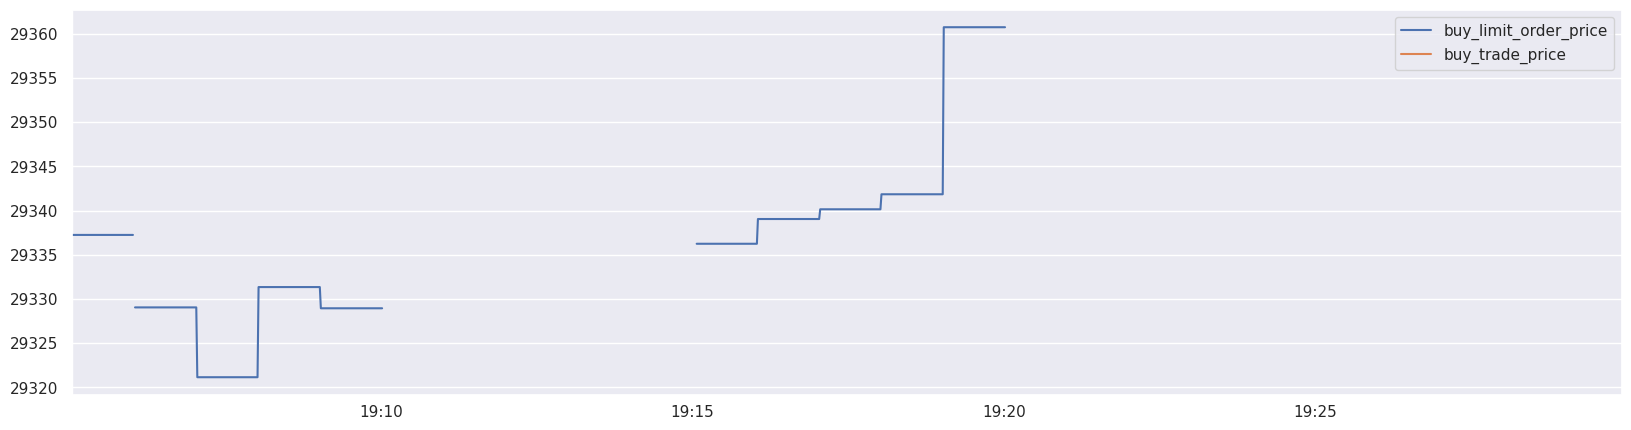

In [75]:
btc_slice[active_cols].plot()

<AxesSubplot: >

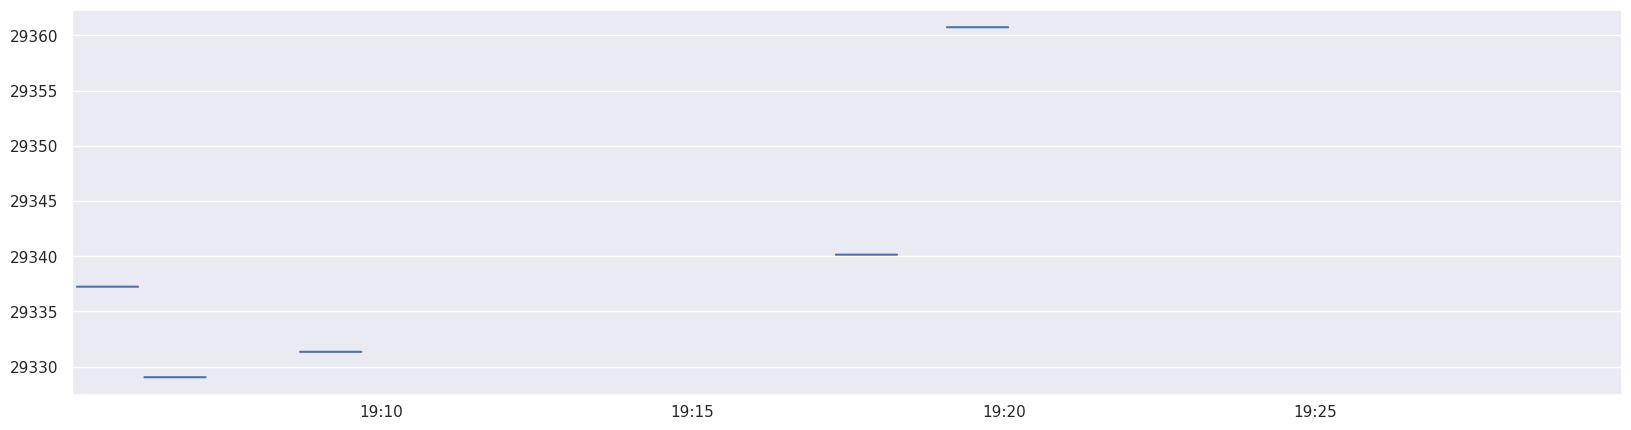

In [76]:
btc_slice["buy_trade_price"].ffill(limit=59).plot()

## Compute simulated trade execution quality against bid-ask benchmarks

In [77]:
simulated_execution_quality_node = dtfcore.GroupedColDfToDfTransformer(
    "simulated_execution_quality",
    transformer_func=cofinanc.compute_bid_ask_execution_quality,
    **{
        "in_col_groups": [
            ("buy_trade_price",),
            ("sell_trade_price",),
            ("bid_price",),
            ("ask_price",),
        ],
        "out_col_group": (),
        "transformer_kwargs": {
            "bid_col": "bid_price",
            "ask_col": "ask_price",
            "buy_trade_price_col": "buy_trade_price",
            "sell_trade_price_col": "sell_trade_price",
        },
    },
)

In [78]:
simulated_execution_quality_df = simulated_execution_quality_node.fit(
    simulated_execution_df
)["df_out"]

/app/helpers/hdbg.py:311: PerformanceWarning: indexing past lexsort depth may impact performance.
  cond = value in valid_values


In [79]:
simulated_execution_quality_df.columns.levels[0].to_list()

['ask_price',
 'bid_ask_midpoint',
 'bid_price',
 'buy_limit_order_price',
 'buy_order_num',
 'buy_trade_midpoint_slippage_bps',
 'buy_trade_midpoint_slippage_notional',
 'buy_trade_price',
 'buy_trade_price_improvement_bps',
 'buy_trade_price_improvement_notional',
 'buy_trade_price_improvement_spread_pct',
 'limit_buy_executed',
 'limit_sell_executed',
 'sell_limit_order_price',
 'sell_order_num',
 'sell_trade_midpoint_slippage_bps',
 'sell_trade_midpoint_slippage_notional',
 'sell_trade_price',
 'sell_trade_price_improvement_bps',
 'sell_trade_price_improvement_notional',
 'sell_trade_price_improvement_spread_pct',
 'spread_bps',
 'spread_notional']

In [80]:
active_cols = ["buy_limit_order_price", "buy_trade_price"]

In [81]:
btc_slice = oms.get_asset_slice(simulated_execution_quality_df, btc_usdt_id)

In [82]:
btc_slice[active_cols].dropna(how="all")

,buy_limit_order_price,buy_trade_price
2023-08-14 19:05:02+00:00,29337.245,NaN
2023-08-14 19:05:03+00:00,29337.245,NaN
2023-08-14 19:05:04+00:00,29337.245,NaN
2023-08-14 19:05:05+00:00,29337.245,NaN
2023-08-14 19:05:06+00:00,29337.245,NaN
...,...,...
2023-08-14 19:19:57+00:00,29360.745,NaN
2023-08-14 19:19:58+00:00,29360.745,NaN
2023-08-14 19:19:59+00:00,29360.745,NaN
2023-08-14 19:20:00+00:00,29360.745,NaN


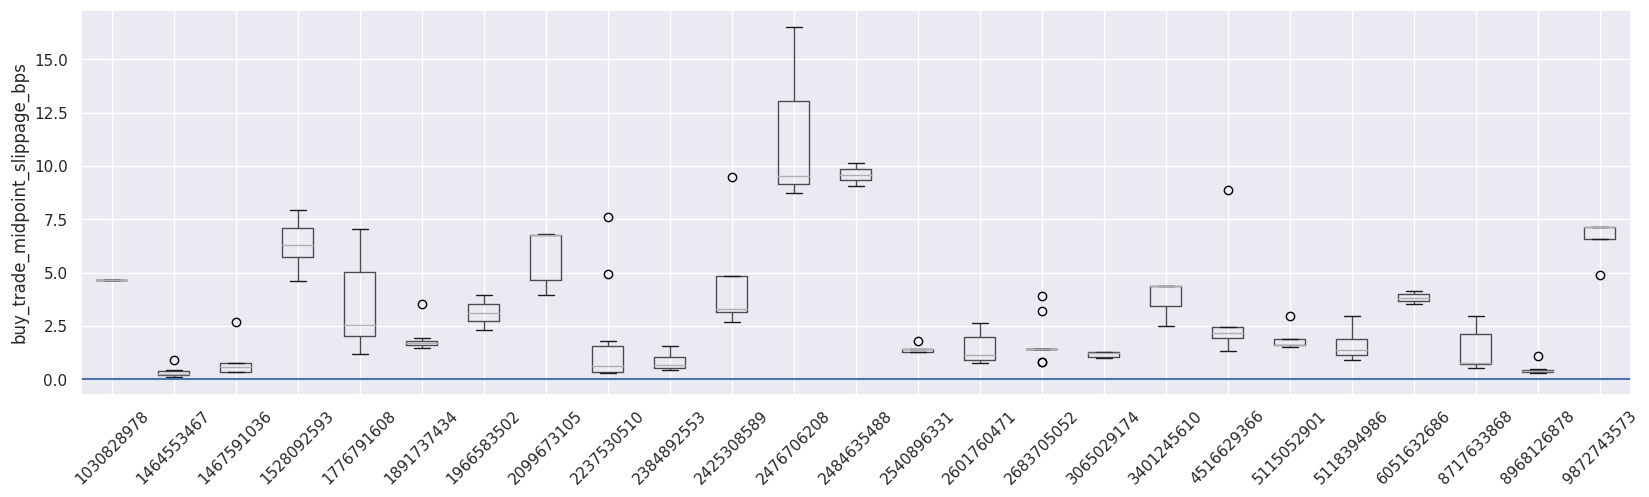

In [83]:
col = "buy_trade_midpoint_slippage_bps"
coplotti.plot_boxplot(
    simulated_execution_quality_df[col], "by_col", ylabel=col
)

<AxesSubplot: >

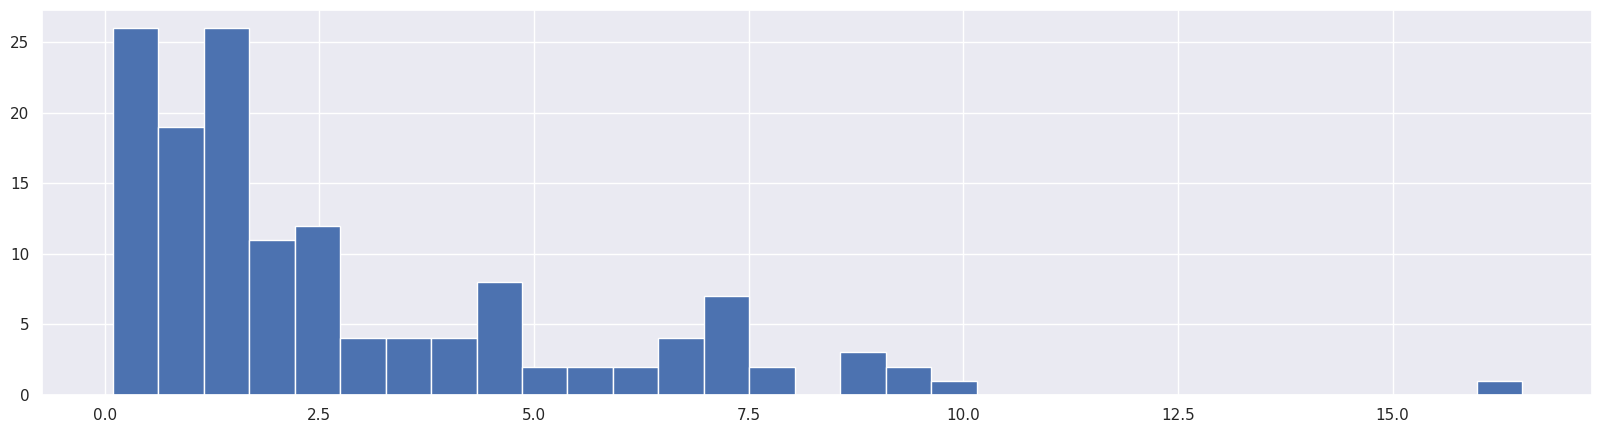

In [84]:
simulated_execution_quality_df["buy_trade_midpoint_slippage_bps"].unstack().hist(
    bins=31
)

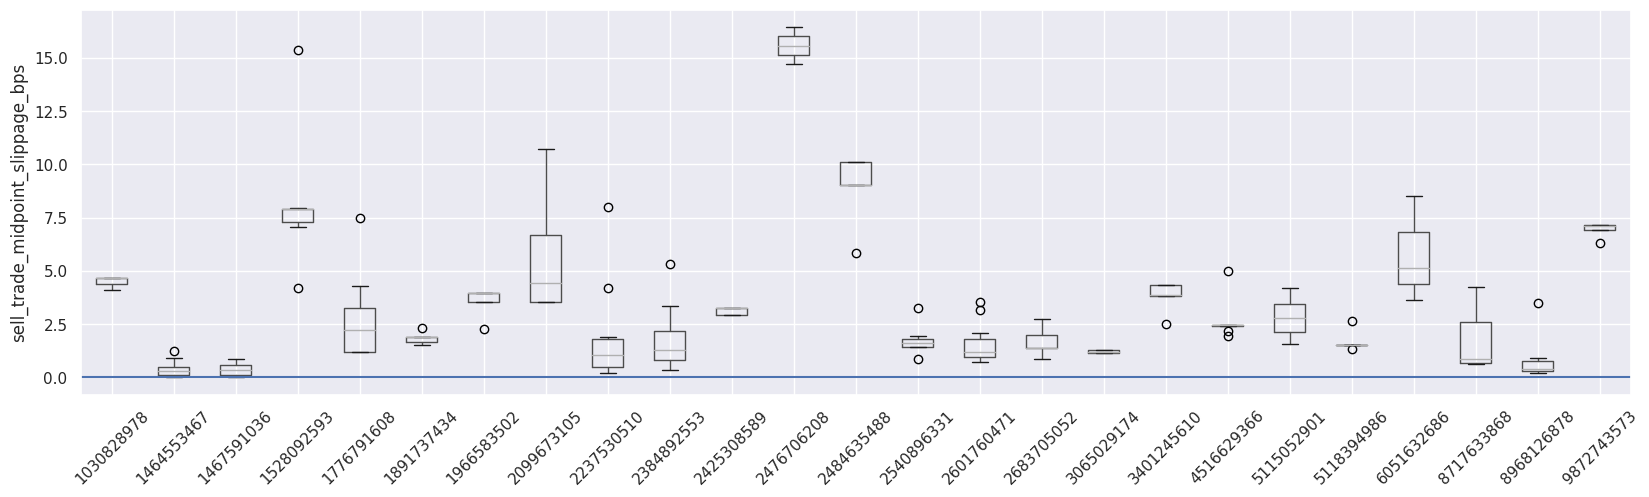

In [85]:
col = "sell_trade_midpoint_slippage_bps"
coplotti.plot_boxplot(
    simulated_execution_quality_df[col], "by_col", ylabel=col
)

<AxesSubplot: >

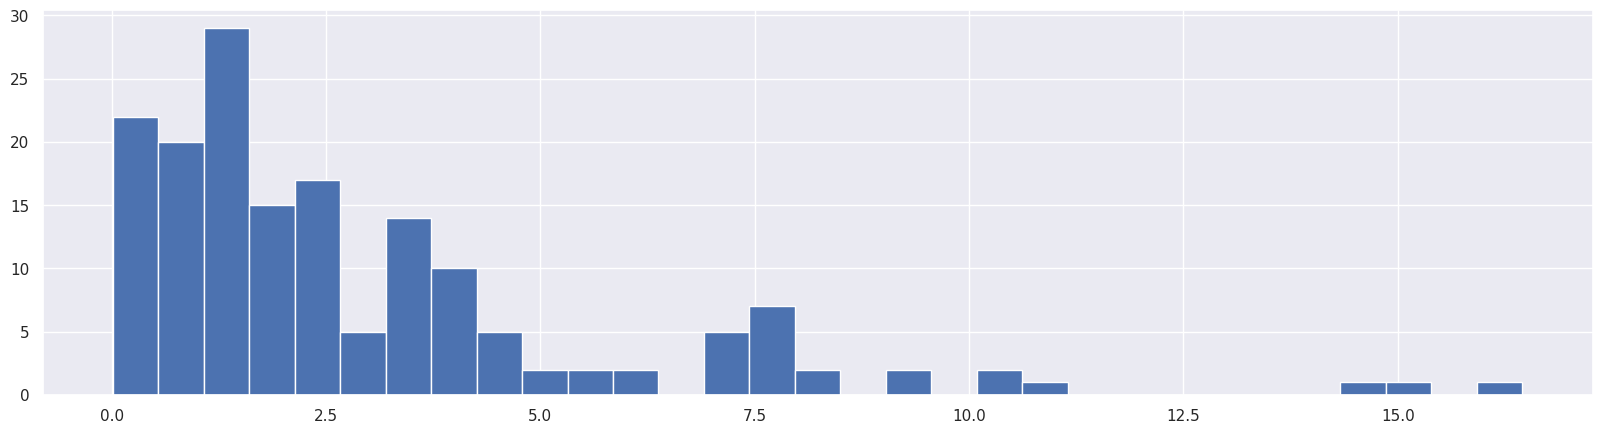

In [86]:
simulated_execution_quality_df["sell_trade_midpoint_slippage_bps"].unstack().hist(
    bins=31
)

In [87]:
costatis.compute_moments(
    simulated_execution_quality_df["buy_trade_midpoint_slippage_bps"].unstack()
)

mean        2.774681
std         2.751135
skew        1.724648
kurtosis    3.744548
dtype: float64

In [88]:
costatis.compute_moments(simulated_execution_quality_df["spread_bps"].unstack())

mean        3.667395
std         3.928725
skew        1.851843
kurtosis    3.522517
dtype: float64

## Compare actual trade prices to simulated trade prices

In [89]:
actual_vs_sim_trade_price_resampling_freq = "1T"

In [90]:
# The "8s" is an empirically-derived estimate of order delay.
simulated_execution_df["sell_limit_order_price"].resample(
    actual_vs_sim_trade_price_resampling_freq,
    closed="right",
    label="right",
    offset="8s",
).mean().head()

,1030828978,1464553467,1467591036,1528092593,1776791608,1891737434,1966583502,2099673105,2237530510,2384892553,2425308589,2476706208,2484635488,2540896331,2601760471,2683705052,3065029174,3401245610,4516629366,5115052901,5118394986,6051632686,8717633868,8968126878,9872743573
2023-08-14 19:05:08+00:00,0.203255,1841.445500,NaN,0.119955,NaN,NaN,0.240455,NaN,NaN,NaN,NaN,NaN,NaN,5.831550,NaN,NaN,0.074075,2.186550,NaN,NaN,0.626755,2.057550,NaN,239.825500,NaN
2023-08-14 19:06:08+00:00,0.203245,1841.421093,NaN,0.119935,NaN,NaN,0.240445,NaN,NaN,NaN,NaN,NaN,NaN,5.831347,NaN,NaN,0.074070,2.186347,NaN,NaN,0.626745,2.057855,NaN,239.824483,NaN
2023-08-14 19:07:08+00:00,0.203145,1841.185500,NaN,0.119755,NaN,NaN,0.240345,NaN,NaN,NaN,NaN,NaN,NaN,5.829550,NaN,NaN,0.074024,2.184450,NaN,NaN,0.626585,2.060450,NaN,239.812500,NaN
2023-08-14 19:08:08+00:00,0.203055,1841.030000,NaN,0.119745,NaN,NaN,0.240265,NaN,NaN,NaN,NaN,NaN,NaN,5.829750,NaN,NaN,0.074016,2.183750,NaN,NaN,0.626015,2.059550,NaN,239.789500,NaN
2023-08-14 19:09:08+00:00,0.203043,1841.192167,NaN,0.119655,NaN,NaN,0.240355,NaN,NaN,NaN,NaN,NaN,NaN,5.831550,NaN,NaN,0.074025,2.185550,NaN,NaN,0.626555,2.059550,NaN,239.825500,NaN


In [91]:
executed_trades_prices = obccagfu.compute_buy_sell_prices_by_bar(
    ccxt_executed_trades_df,
    actual_vs_sim_trade_price_resampling_freq,
    offset="8s",
    groupby_id_col="asset_id",
)
executed_trades_prices.head()

buy_trade_price                                                                                                                                                                                                                                                                         sell_trade_price                                                                                                                                                                                                                                                                        
asset_id                       1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573       1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573
bar_end_datetime                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
2023-08-14 19:06:08+00:00             NaN        NaN    29337.2        NaN      4.189      4.975        NaN      1.402     24.742     1.8921     0.2901        NaN        NaN        NaN      7.410     0.6761        NaN        NaN     0.3888     0.5936        NaN        NaN     12.278        NaN      1.329              NaN        NaN        NaN     0.1200        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN    0.07408        NaN        NaN        NaN     0.6268      2.058        NaN        NaN        NaN
2023-08-14 19:07:08+00:00             NaN        NaN    29324.4        NaN      4.186        NaN        NaN      1.401     24.719     1.8916     0.2901      0.577        NaN        NaN      7.403     0.6758        NaN        NaN     0.3886        NaN        NaN        NaN     12.273        NaN      1.328              NaN    1841.21        NaN     0.1198        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN      5.830        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN     239.82        NaN
2023-08-14 19:08:08+00:00             NaN        NaN        NaN        NaN      4.184        NaN        NaN        NaN     24.697     1.8905        NaN      0.576        NaN        NaN      7.402        NaN        NaN        NaN        NaN        NaN        NaN        NaN     12.263        NaN        NaN              NaN    1841.01        NaN        NaN        NaN        NaN     0.2403        NaN        NaN        NaN        NaN        NaN        NaN      5.830        NaN        NaN    0.07402      2.184        NaN        NaN     0.6260        NaN        NaN     239.79        NaN
2023-08-14 19:09:08+00:00             NaN        NaN    29331.3        NaN        NaN      4.974        NaN      1.401     24.710     1.8908     0.2900        NaN        NaN        NaN      7.406     0.6761        NaN        NaN     0.3886        NaN        NaN        NaN     12.263        NaN        NaN              NaN    1841.22        NaN     0.1197        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN      5.832        NaN        NaN        NaN      

In [92]:
resampled_simulated_execution_df = simulated_execution_df.resample(
    actual_vs_sim_trade_price_resampling_freq,
    closed="right",
    label="right",
    offset="8s",
).mean()
resampled_simulated_execution_df.head()

buy_trade_price                                                                                                                                                                                                                                                                         limit_buy_executed                                                                                                                                                                                                                                                                         limit_sell_executed                                                                                                                                                                                                                                                                         sell_trade_price                                                                                                     \
                               1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573         1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573          1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573       1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553   
2023-08-14 19:05:08+00:00             NaN        NaN  29337.245        NaN        NaN        NaN        NaN        NaN   24.74245        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN                0.0        0.0   0.142857        0.0   0.000000   0.000000        0.0   0.000000   0.142857   0.000000   0.000000   0.000000        0.0        0.0   0.000000   0.000000        0.0        0.0   0.000000   0.000000        0.0        0.0   0.000000        0.0   0.000000                 0.0   0.000000        0.0   0.000000        0.0        0.0   0.000000        0.0        0.0        0.0        0.0        0.0        0.0   0.000000        0.0        0.0   0.000000   0.000000        0.0        0.0   0.142857   0.000000        0.0   0.000000        0.0              NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN   
2023-08-14 19:06:08+00:00             NaN        NaN        NaN        NaN    4.18945    4.97545        NaN    1.40245        NaN   1.892145        NaN        NaN        NaN        NaN    7.41045   0.676145        NaN        NaN   0.388845   0.593645        NaN        NaN   12.27845        NaN    1.32945                0.0        0.0   0.000000        0.0   0.016667   0.016667        0.0   0.016667   0.000000   0.016667   0.000000   0.000000        0.0        0.0   0.016667   0.016667        0.0        0.0   0.016667   0.016667        0.0        0.0   0.016667        0.0   0.016667                 0.0   0.000000        0.0   0.000000        0.0        0.0   0.000000        0.0        0.0        0.0        0.0        0.0        0.0   0.000000        0.0        0.0   0.000000   0.000000        0.0        0.0   0.000000   0.016667        0.0   0.000000        0.0              NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN   
2023-08-14 19:07:08+00:00             NaN        NaN  2932

In [93]:
actual_executed_trades_prices = obccagfu.compute_buy_sell_prices_by_bar(
    ccxt_executed_trades_df, "1s", offset="0s", groupby_id_col="asset_id"
)

In [94]:
def combine_sim_and_actual_trades(simulated_execution_df, fills, freq, offset):
    #
    actual_executed_trades_prices = obccagfu.compute_buy_sell_prices_by_bar(
        fills,
        freq,
        offset=offset,
        groupby_id_col="asset_id",
    )
    resampled_simulated_execution_df = simulated_execution_df.resample(
        freq,
        closed="right",
        label="right",
        offset=offset,
    ).mean()
    #
    col_set = actual_executed_trades_prices.columns.levels[1].union(
        resampled_simulated_execution_df.columns.levels[1]
    )
    col_set = col_set.sort_values()
    #
    trade_price_dict = {
        "actual_buy_trade_price": actual_executed_trades_prices[
            "buy_trade_price"
        ].reindex(columns=col_set),
        "actual_sell_trade_price": actual_executed_trades_prices[
            "sell_trade_price"
        ].reindex(columns=col_set),
        "simulated_buy_trade_price": resampled_simulated_execution_df[
            "buy_trade_price"
        ].reindex(columns=col_set),
        "simulated_sell_trade_price": resampled_simulated_execution_df[
            "sell_trade_price"
        ].reindex(columns=col_set),
    }
    simulated_and_actual_trade_price_df = pd.concat(trade_price_dict, axis=1)
    return simulated_and_actual_trade_price_df

In [95]:
actual_vs_sim_trade_price_resampling_freq = "5T"

In [96]:
simulated_and_actual_trade_price_df = combine_sim_and_actual_trades(
    simulated_execution_df,
    ccxt_executed_trades_df,
    actual_vs_sim_trade_price_resampling_freq,
    offset="8s",
)
simulated_and_actual_trade_price_df.head()

actual_buy_trade_price                                                                                                                                                                                                                                                                             actual_sell_trade_price                                                                                                                                                                                                                                                                            simulated_buy_trade_price                                                                                                                                                                                                                                                                          simulated_sell_trade_price                                                                         \
                                      1030828978 1464553467    1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868  8968126878 9872743573              1030828978 1464553467    1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573                1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868  8968126878 9872743573                 1030828978   1464553467    1467591036 1528092593 1776791608 1891737434 1966583502   
2023-08-14 19:05:08+00:00                    NaN        NaN           NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN         NaN        NaN                     NaN        NaN           NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN                       NaN        NaN  29337.245        NaN        NaN        NaN        NaN        NaN  24.742450        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN         NaN        NaN                        NaN          NaN           NaN        NaN        NaN        NaN        NaN   
2023-08-14 19:10:08+00:00                    NaN        NaN  29330.966667        NaN    4.18800   4.973667        NaN   1.401333  24.713600    1.89125   0.290067     0.5765        NaN        NaN   7.405400    0.67600        NaN        NaN   0.388667   0.593600        NaN        NaN  12.269250         NaN     1.3285                     NaN  1841.1150           NaN    0.11980        NaN        NaN    0.24030        NaN        NaN        NaN        NaN        NaN        NaN    5.83100        NaN        NaN   0.074043   2.185000        NaN        NaN   0.626467      2.058        NaN   239.8175        NaN                       NaN        NaN  29330.195        NaN   4.188450   4.974117        NaN   1.401783  24.708950   1.891295   0.290095    0.57695        NaN        NaN   7.405700   0.676045        NaN        NaN   0.388712   0.593645        NaN        NaN  12.269700         NaN    1.32895                        NaN  1841.010500           NaN   0.119705   4.195550        NaN   0.240255   
2023-08-14 19:15:08+00:00 

In [97]:
oms.get_asset_slice(simulated_and_actual_trade_price_df, btc_usdt_id)[
    ["actual_buy_trade_price", "simulated_buy_trade_price"]
].dropna(how="all")

,actual_buy_trade_price,simulated_buy_trade_price
2023-08-14 19:05:08+00:00,NaN,29337.245
2023-08-14 19:10:08+00:00,29330.966667,29330.195
2023-08-14 19:20:08+00:00,29346.600000,29350.445


In [98]:
oms.get_asset_slice(simulated_and_actual_trade_price_df, btc_usdt_id)[
    ["actual_sell_trade_price", "simulated_sell_trade_price"]
].dropna(how="all")

,actual_sell_trade_price,simulated_sell_trade_price
2023-08-14 19:15:08+00:00,29329.933333,29329.888333
2023-08-14 19:25:08+00:00,29360.325000,29360.286250


In [99]:
execution_quality_node = dtfcore.GroupedColDfToDfTransformer(
    "execution_quality",
    transformer_func=cofinanc.compute_ref_price_execution_quality,
    **{
        "in_col_groups": [
            ("actual_buy_trade_price",),
            ("actual_sell_trade_price",),
            ("simulated_buy_trade_price",),
            ("simulated_sell_trade_price",),
        ],
        "out_col_group": (),
        "transformer_kwargs": {
            "buy_trade_reference_price_col": "simulated_buy_trade_price",
            "sell_trade_reference_price_col": "simulated_sell_trade_price",
            "buy_trade_price_col": "actual_buy_trade_price",
            "sell_trade_price_col": "actual_sell_trade_price",
        },
    },
)

In [100]:
sim_vs_actual_execution_quality_df = execution_quality_node.fit(
    simulated_and_actual_trade_price_df
)["df_out"]

In [101]:
sim_vs_actual_execution_quality_df.columns.levels[0].to_list()

['actual_buy_trade_price',
 'actual_sell_trade_price',
 'buy_trade_slippage_bps',
 'buy_trade_slippage_notional',
 'sell_trade_slippage_bps',
 'sell_trade_slippage_notional',
 'simulated_buy_trade_price',
 'simulated_sell_trade_price']

In [102]:
oms.get_asset_slice(sim_vs_actual_execution_quality_df, btc_usdt_id)

,buy_trade_slippage_bps,buy_trade_slippage_notional,sell_trade_slippage_bps,sell_trade_slippage_notional,actual_buy_trade_price,actual_sell_trade_price,simulated_buy_trade_price,simulated_sell_trade_price
2023-08-14 19:05:08+00:00,NaN,NaN,NaN,NaN,NaN,NaN,29337.245,NaN
2023-08-14 19:10:08+00:00,0.263096,0.771667,NaN,NaN,29330.966667,NaN,29330.195,NaN
2023-08-14 19:15:08+00:00,NaN,NaN,-0.015343,-0.04500,NaN,29329.933333,NaN,29329.888333
2023-08-14 19:20:08+00:00,-1.310031,-3.845000,NaN,NaN,29346.600000,NaN,29350.445,NaN
2023-08-14 19:25:08+00:00,NaN,NaN,-0.013198,-0.03875,NaN,29360.325000,NaN,29360.286250
2023-08-14 19:30:08+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


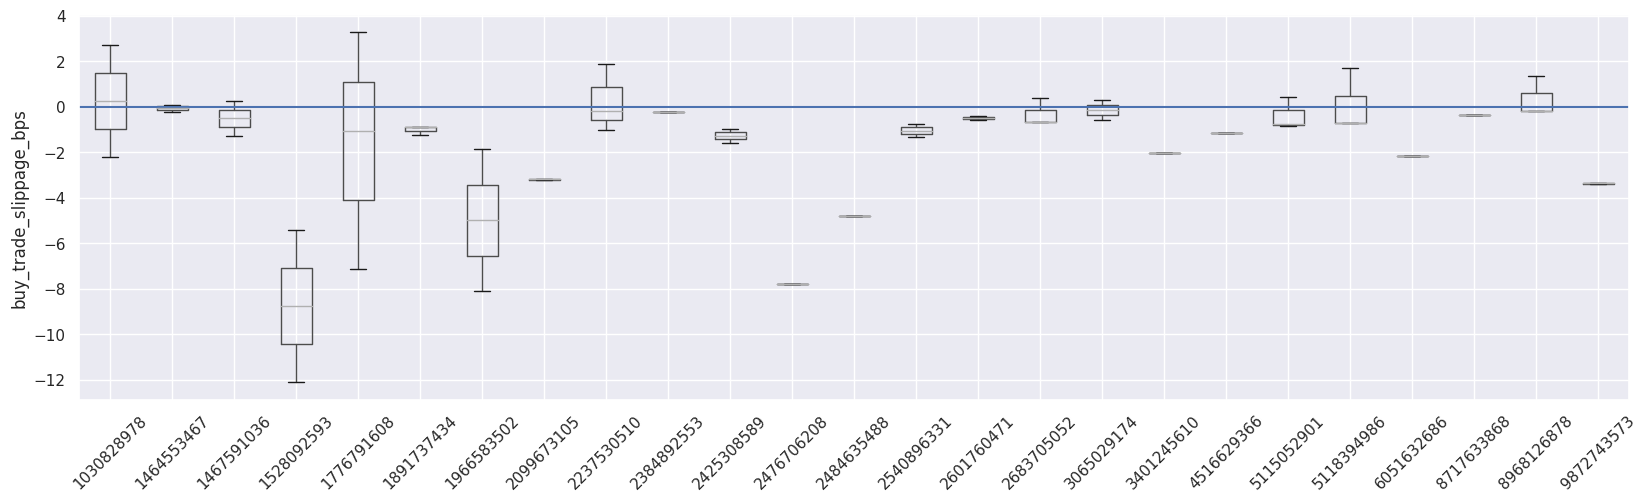

In [103]:
col = "buy_trade_slippage_bps"
coplotti.plot_boxplot(
    sim_vs_actual_execution_quality_df[col], "by_col", ylabel=col
)

<AxesSubplot: >

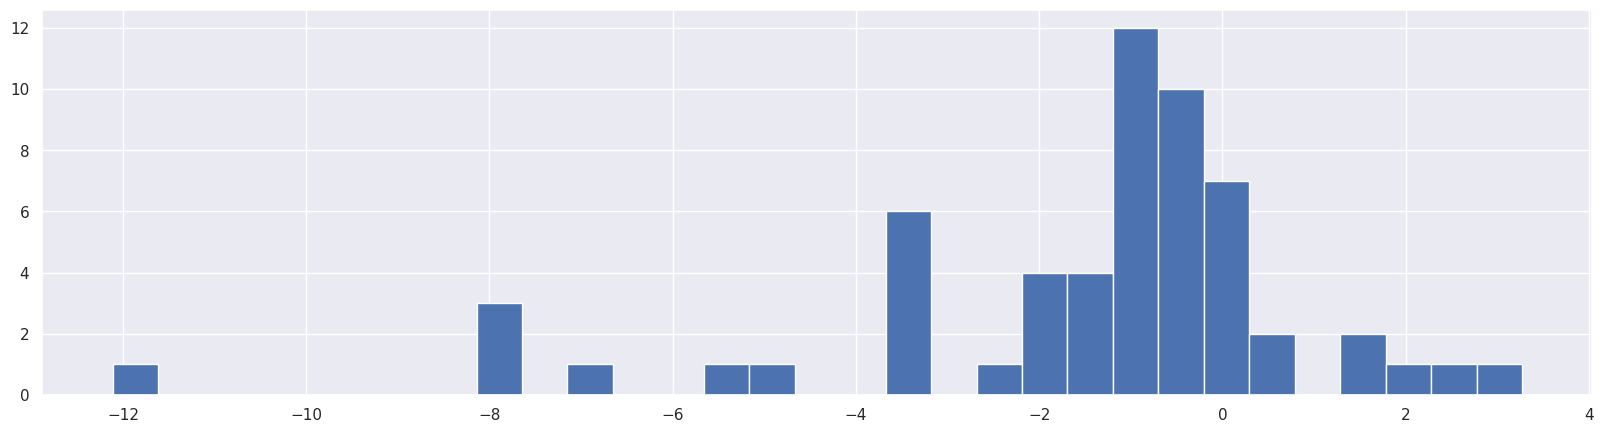

In [104]:
sim_vs_actual_execution_quality_df["buy_trade_slippage_bps"].unstack().hist(
    bins=31
)

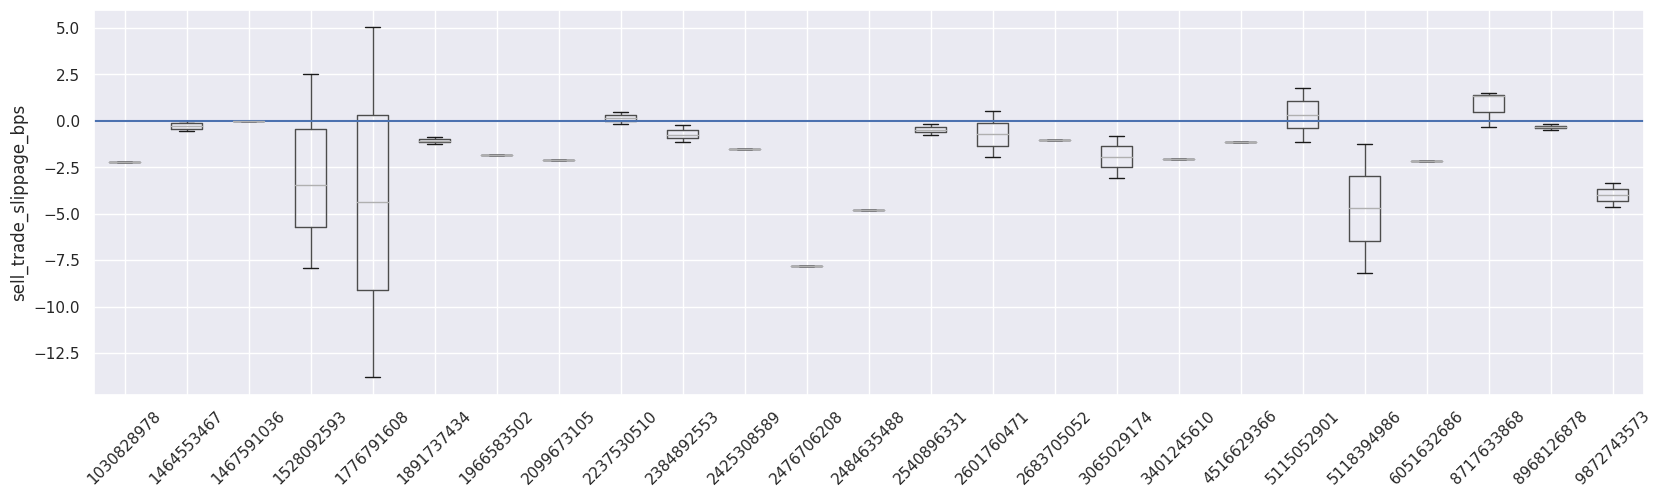

In [105]:
col = "sell_trade_slippage_bps"
coplotti.plot_boxplot(
    sim_vs_actual_execution_quality_df[col], "by_col", ylabel=col
)

<AxesSubplot: >

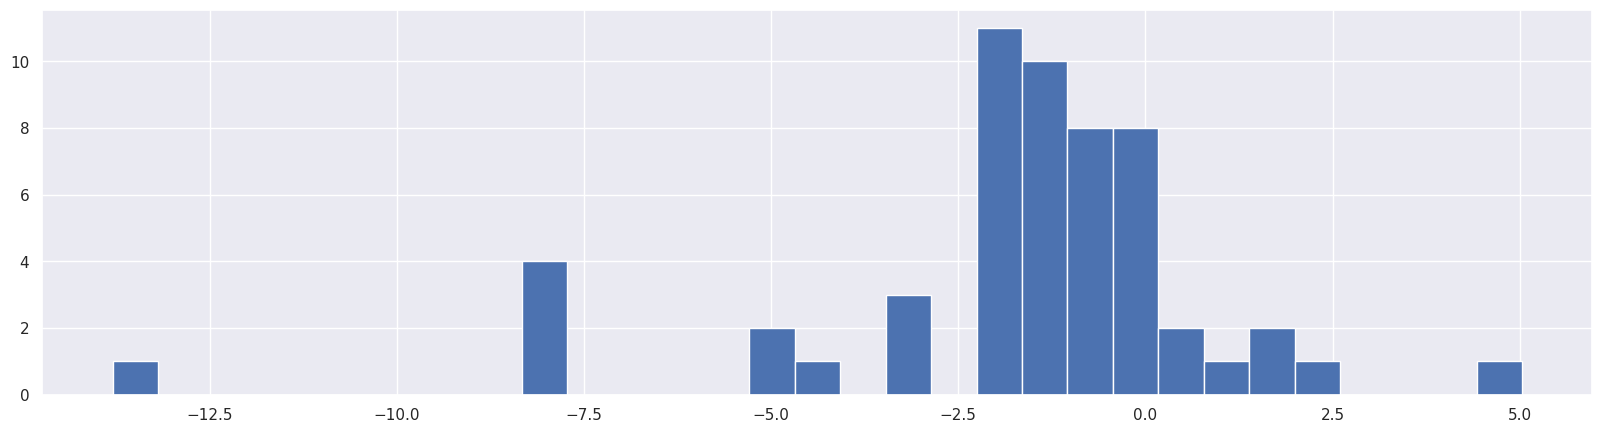

In [106]:
sim_vs_actual_execution_quality_df["sell_trade_slippage_bps"].unstack().hist(
    bins=31
)

# Simulate limit order generation and trades

- Specify buy/sell aggressiveness parameters
- Specify repricing frequency and time-in-force
- Simulate average execution prices and percentage of bars filled

In [107]:
def get_data():
    return bad

In [108]:
dag_builder = dtfpexexpi.ExecutionPipeline()
#
config = dag_builder.get_config_template()
# Set up `overwrite` mode to allow reassignment of values.
# Note: by default the `update_mode` does not allow overwrites,
# but they are required by the FeaturePipeline.
config.update_mode = "overwrite"
_LOG.debug("config from dag_builder=%s", config)
# Initialize config.
config["load_data"] = cconfig.Config.from_dict(
    {
        "source_node_name": "FunctionDataSource",
        "source_node_kwargs": {
            "func": get_data,
        },
    }
)
config["resample", "transformer_kwargs", "rule"] = "1T"
config["resample", "transformer_kwargs", "resample_kwargs", "offset"] = "8s"
config[
    "generate_limit_orders", "transformer_kwargs", "buy_spread_frac_offset"
] = 0.45
config[
    "generate_limit_orders", "transformer_kwargs", "sell_spread_frac_offset"
] = -0.45
config["generate_limit_orders", "transformer_kwargs", "subsample_freq"] = "60s"
config["generate_limit_orders", "transformer_kwargs", "freq_offset"] = "9s"
config["generate_limit_orders", "transformer_kwargs", "ffill_limit"] = 59

#
_LOG.debug("config after patching=%s", config)
dag = dag_builder.get_dag(config)

In [109]:
bid_ask_sim_flow_df = dag.run_leq_node(
    "compute_trade_vs_limit_execution_quality", "fit"
)["df_out"]

run_leq_node:   0%|          | 0/5 [00:00<?, ?it/s]

/app/helpers/hdbg.py:311: PerformanceWarning: indexing past lexsort depth may impact performance.
  cond = value in valid_values
/app/helpers/hdbg.py:311: PerformanceWarning: indexing past lexsort depth may impact performance.
  cond = value in valid_values


In [110]:
bid_ask_sim_flow_df.columns.levels[0].to_list()

['ask_price',
 'bid_ask_midpoint',
 'bid_price',
 'buy_limit_order_price',
 'buy_order_num',
 'buy_trade_limit_slippage_bps',
 'buy_trade_limit_slippage_notional',
 'buy_trade_midpoint_slippage_bps',
 'buy_trade_midpoint_slippage_notional',
 'buy_trade_price',
 'buy_trade_price_improvement_bps',
 'buy_trade_price_improvement_notional',
 'buy_trade_price_improvement_spread_pct',
 'limit_buy_executed',
 'limit_sell_executed',
 'sell_limit_order_price',
 'sell_order_num',
 'sell_trade_limit_slippage_bps',
 'sell_trade_limit_slippage_notional',
 'sell_trade_midpoint_slippage_bps',
 'sell_trade_midpoint_slippage_notional',
 'sell_trade_price',
 'sell_trade_price_improvement_bps',
 'sell_trade_price_improvement_notional',
 'sell_trade_price_improvement_spread_pct',
 'spread_bps',
 'spread_notional']

In [111]:
btc_df = oms.get_asset_slice(bid_ask_sim_flow_df, btc_usdt_id)

In [112]:
btc_df[
    [
        "bid_price",
        "ask_price",
        "buy_order_num",
        "buy_trade_price",
        "buy_limit_order_price",
    ]
]

,bid_price,ask_price,buy_order_num,buy_trade_price,buy_limit_order_price
knowledge_timestamp,,,,,
2023-08-14 19:05:08+00:00,29336.990000,29337.090000,NaN,NaN,NaN
2023-08-14 19:06:08+00:00,29330.505667,29330.605667,1.0,29336.045,29336.045
2023-08-14 19:07:08+00:00,29321.495000,29321.595000,2.0,29329.045,29329.045
2023-08-14 19:08:08+00:00,29326.987481,29327.087481,3.0,NaN,29321.145
2023-08-14 19:09:08+00:00,29330.560667,29330.660667,4.0,29331.345,29331.345
2023-08-14 19:10:08+00:00,29332.643000,29332.743000,5.0,29333.645,29333.645
2023-08-14 19:11:08+00:00,29330.326333,29330.426333,6.0,29331.645,29331.645
2023-08-14 19:12:08+00:00,29330.570500,29330.670500,7.0,NaN,29328.345
2023-08-14 19:13:08+00:00,29330.056833,29330.156833,8.0,29331.545,29331.545


In [113]:
bid_ask_sim_flow_df.head()

buy_trade_limit_slippage_bps                                                                                                                                                                                                                                                                                  buy_trade_limit_slippage_notional                                                                                                                                                                                                                                                                                  sell_trade_limit_slippage_bps                                                                                                                                                                                                                                                                                  sell_trade_limit_slippage_notional                           \
                                            1030828978    1464553467    1467591036 1528092593 1776791608 1891737434 1966583502    2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573                        1030828978    1464553467    1467591036 1528092593 1776791608 1891737434 1966583502    2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573                    1030828978 1464553467    1467591036 1528092593 1776791608 1891737434 1966583502 2099673105    2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610    4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573                         1030828978 1464553467    1467591036   
knowledge_timestamp                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
2023-08-14 19:05:08+00:00                          NaN           NaN           NaN        NaN        NaN        NaN        NaN           NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN                               NaN           NaN           NaN        NaN        NaN        NaN        NaN           NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN                           NaN        NaN           NaN        NaN        NaN        NaN        NaN        NaN           NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN           NaN        NaN        NaN        NaN        NaN        NaN        NaN                                NaN        NaN           NaN   
2023-08-14 19:06:08+00

<AxesSubplot: xlabel='knowledge_timestamp'>

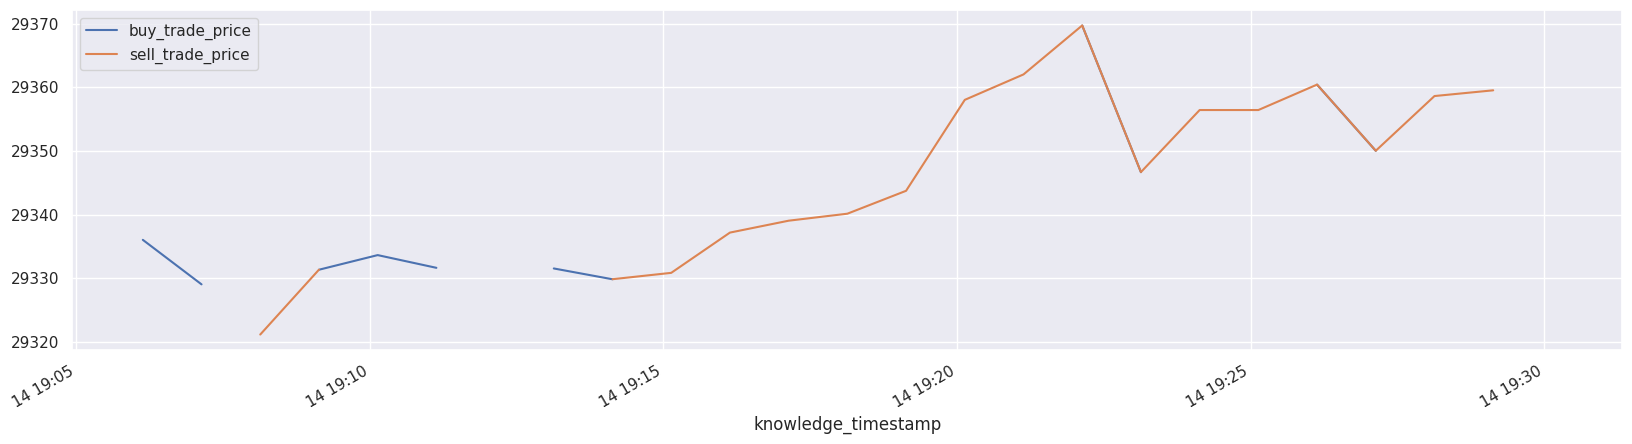

In [114]:
oms.get_asset_slice(bid_ask_sim_flow_df, btc_usdt_id)[
    ["buy_trade_price", "sell_trade_price"]
].plot()

In [115]:
oms.get_asset_slice(bid_ask_sim_flow_df, btc_usdt_id).head()

,buy_trade_limit_slippage_bps,buy_trade_limit_slippage_notional,sell_trade_limit_slippage_bps,sell_trade_limit_slippage_notional,bid_ask_midpoint,buy_trade_midpoint_slippage_bps,buy_trade_midpoint_slippage_notional,buy_trade_price_improvement_bps,buy_trade_price_improvement_notional,buy_trade_price_improvement_spread_pct,sell_trade_midpoint_slippage_bps,sell_trade_midpoint_slippage_notional,sell_trade_price_improvement_bps,sell_trade_price_improvement_notional,sell_trade_price_improvement_spread_pct,spread_bps,spread_notional,ask_price,bid_price,buy_limit_order_price,buy_order_num,buy_trade_price,limit_buy_executed,limit_sell_executed,sell_limit_order_price,sell_order_num,sell_trade_price
knowledge_timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-08-14 19:05:08+00:00,NaN,NaN,NaN,NaN,29337.040000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.034087,0.1,29337.090000,29336.990000,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN
2023-08-14 19:06:08+00:00,0.000000e+00,0.000000e+00,NaN,NaN,29330.555667,1.871541,5.489333,-1.854491,-5.439333,-5439.333334,NaN,NaN,NaN,NaN,NaN,0.034094,0.1,29330.605667,29330.505667,29336.045,1.0,29336.045,0.016667,0.000000,29336.055,1.0,NaN
2023-08-14 19:07:08+00:00,0.000000e+00,0.000000e+00,NaN,NaN,29321.545000,2.557846,7.500000,-2.540789,-7.450000,-7450.000000,NaN,NaN,NaN,NaN,NaN,0.034105,0.1,29321.595000,29321.495000,29329.045,2.0,29329.045,0.016667,0.000000,29329.055,2.0,NaN
2023-08-14 19:08:08+00:00,NaN,NaN,-1.240735e-12,-3.637979e-12,29327.037481,NaN,NaN,NaN,NaN,NaN,2.005822,5.882481,-1.988776,-5.832481,-5832.481481,0.034098,0.1,29327.087481,29326.987481,29321.145,3.0,NaN,0.000000,0.016667,29321.155,3.0,29321.155
2023-08-14 19:09:08+00:00,-1.240304e-12,-3.637979e-12,0.000000e+00,0.000000e+00,29330.610667,0.250364,0.734333,-0.233317,-0.684333,-684.333333,-0.253774,-0.744333,0.270821,0.794333,794.333333,0.034094,0.1,29330.660667,29330.560667,29331.345,4.0,29331.345,0.016667,0.016667,29331.355,4.0,29331.355


In [116]:
btc_simulated_prices = oms.get_asset_slice(bid_ask_sim_flow_df, btc_usdt_id)

In [117]:
active_cols = ["buy_limit_order_price", "buy_trade_price"]

<AxesSubplot: xlabel='knowledge_timestamp'>

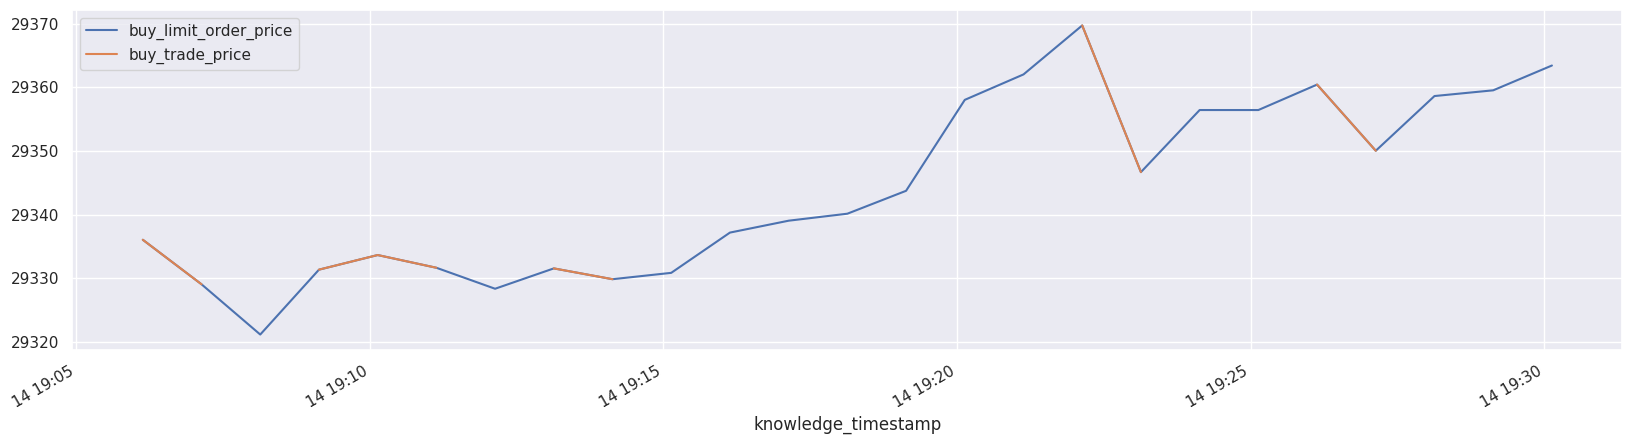

In [118]:
btc_simulated_prices[active_cols].dropna(how="all").plot()

In [119]:
# col = "buy_trade_midpoint_slippage_bps"
# coplotti.plot_boxplot(df_out[col], "by_row", ylabel=col)

In [120]:
# col = "sell_trade_midpoint_slippage_bps"
# coplotti.plot_boxplot(df_out[col], "by_row", ylabel=col)

In [121]:
costatis.compute_moments(
    bid_ask_sim_flow_df["buy_trade_limit_slippage_bps"].unstack()
)

mean          0.023605
std           0.311634
skew         14.750249
kurtosis    224.905073
dtype: float64

In [122]:
costatis.compute_moments(
    bid_ask_sim_flow_df["sell_trade_limit_slippage_bps"].unstack()
)

mean        6.231206e-16
std         3.610943e-13
skew        6.301565e-01
kurtosis    1.611002e+01
dtype: float64

# Compare simulated limit orders and actual limit orders

In [123]:
simulated_buy_limits = bid_ask_sim_flow_df["buy_limit_order_price"]

In [124]:
simulated_buy_limits.head()

,1030828978,1464553467,1467591036,1528092593,1776791608,1891737434,1966583502,2099673105,2237530510,2384892553,2425308589,2476706208,2484635488,2540896331,2601760471,2683705052,3065029174,3401245610,4516629366,5115052901,5118394986,6051632686,8717633868,8968126878,9872743573
knowledge_timestamp,,,,,,,,,,,,,,,,,,,,,,,,,
2023-08-14 19:05:08+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-08-14 19:06:08+00:00,0.203245,1841.4445,29336.045,0.119956,4.196200,4.97545,0.240445,1.40245,24.73745,1.892145,0.290145,0.57745,0.093745,5.83145,7.41045,0.676145,0.074074,2.18645,0.388845,0.593645,0.626745,2.05745,12.27845,239.8245,1.32945
2023-08-14 19:07:08+00:00,0.203145,1841.2045,29329.045,0.119745,4.186450,4.97245,0.240345,1.40145,24.72445,1.891645,0.290145,0.57745,0.093745,5.82945,7.40345,0.675845,0.074024,2.18495,0.388645,0.593445,0.626645,2.06045,12.27345,239.8145,1.32845
2023-08-14 19:08:08+00:00,0.203045,1841.0045,29321.145,0.119745,4.183575,4.97245,0.240245,1.40145,24.69815,1.890545,0.289845,0.57645,0.093745,5.82945,7.40245,0.675945,0.074004,2.18345,0.388445,0.593945,0.626035,2.05945,12.26305,239.8065,1.32745
2023-08-14 19:09:08+00:00,0.203045,1841.2145,29331.345,0.119645,4.192450,4.97445,0.240345,1.40145,24.71245,1.890745,0.290045,0.57645,0.093745,5.83245,7.40645,0.676235,0.074024,2.18545,0.388645,0.594174,0.626545,2.05945,12.26345,239.8245,1.32945


In [125]:
actual_buy_limits = in_df["buy_limit_order_price"]

In [126]:
actual_buy_limits.head()

asset_id,1030828978,1464553467,1467591036,1528092593,1776791608,1891737434,1966583502,2099673105,2237530510,2384892553,2425308589,2476706208,2484635488,2540896331,2601760471,2683705052,3065029174,3401245610,4516629366,5115052901,5118394986,6051632686,8717633868,8968126878,9872743573
2023-08-14 19:05:02+00:00,NaN,NaN,29337.245,NaN,4.18945,4.97545,NaN,1.40245,24.74245,1.892145,0.290145,0.57745,0.093745,NaN,7.41045,0.676145,NaN,NaN,0.388845,0.593645,NaN,NaN,12.27845,NaN,1.32945
2023-08-14 19:05:03+00:00,NaN,NaN,29337.245,NaN,4.18945,4.97545,NaN,1.40245,24.74245,1.892145,0.290145,0.57745,0.093745,NaN,7.41045,0.676145,NaN,NaN,0.388845,0.593645,NaN,NaN,12.27845,NaN,1.32945
2023-08-14 19:05:04+00:00,NaN,NaN,29337.245,NaN,4.18945,4.97545,NaN,1.40245,24.74245,1.892145,0.290145,0.57745,0.093745,NaN,7.41045,0.676145,NaN,NaN,0.388845,0.593645,NaN,NaN,12.27845,NaN,1.32945
2023-08-14 19:05:05+00:00,NaN,NaN,29337.245,NaN,4.18945,4.97545,NaN,1.40245,24.74245,1.892145,0.290145,0.57745,0.093745,NaN,7.41045,0.676145,NaN,NaN,0.388845,0.593645,NaN,NaN,12.27845,NaN,1.32945
2023-08-14 19:05:06+00:00,NaN,NaN,29337.245,NaN,4.18945,4.97545,NaN,1.40245,24.74245,1.892145,0.290145,0.57745,0.093745,NaN,7.41045,0.676145,NaN,NaN,0.388845,0.593645,NaN,NaN,12.27845,NaN,1.32945


In [127]:
lim_vs_lim = pd.concat(
    {
        "simulated_buy_limit": simulated_buy_limits,
        "actual_buy_limit": actual_buy_limits.resample(
            "1T", offset="8s", closed="right", label="right"
        ).mean(),
    },
    axis=1,
)

In [128]:
lim_vs_lim.columns.levels[1]

Int64Index([1030828978, 1464553467, 1467591036, 1528092593, 1776791608, 1891737434, 1966583502, 2099673105, 2237530510, 2384892553, 2425308589, 2476706208, 2484635488, 2540896331, 2601760471, 2683705052, 3065029174, 3401245610, 4516629366, 5115052901, 5118394986, 6051632686, 8717633868, 8968126878, 9872743573], dtype='int64')

<AxesSubplot: >

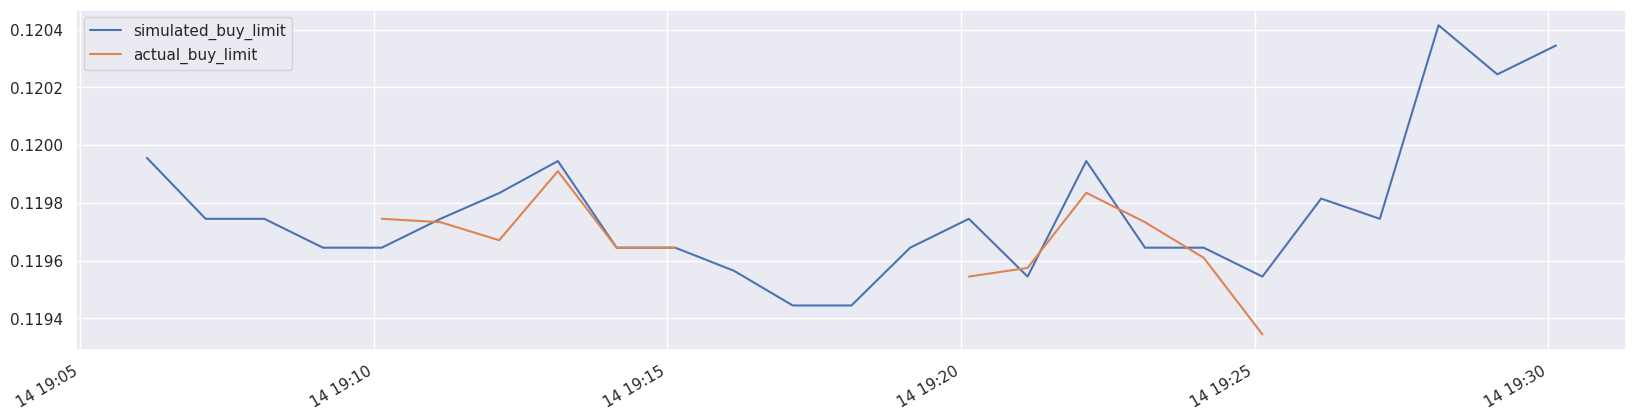

In [129]:
oms.get_asset_slice(lim_vs_lim, lim_vs_lim.columns.levels[1][3]).dropna(
    how="all"
).plot()

<AxesSubplot: >

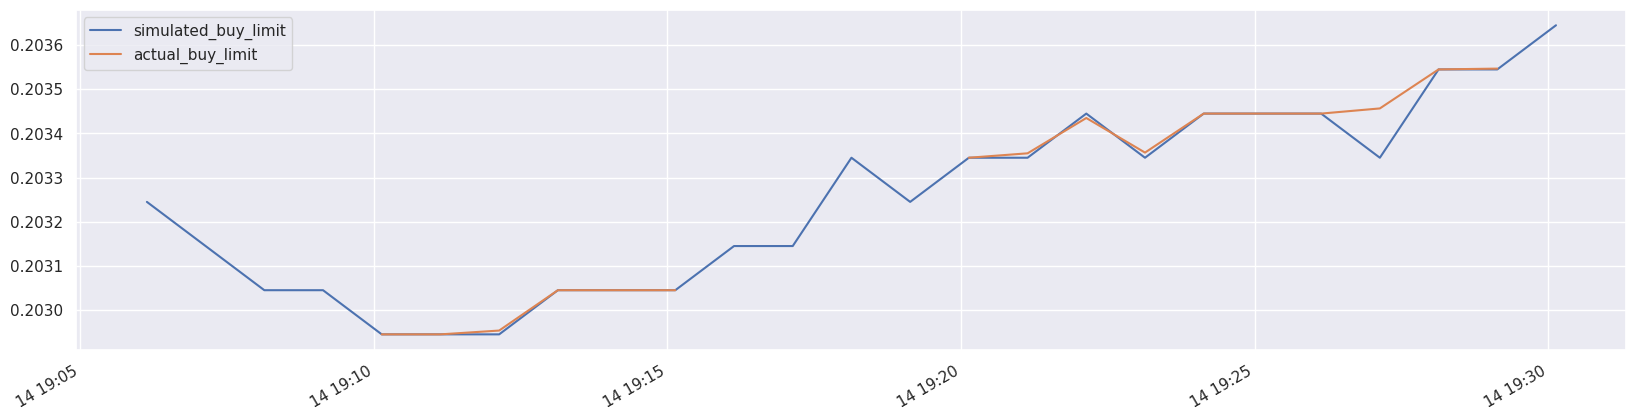

In [130]:
oms.get_asset_slice(lim_vs_lim, lim_vs_lim.columns.levels[1][0]).dropna(
    how="all"
).plot()